# Geospatial Analysis Tutorial: Exploring Global Earthquakes

**Objective:** This tutorial will guide you through loading, visualizing, and analyzing global earthquake data using Python's geospatial libraries. We'll cover concepts similar to those in the Kaggle Geospatial Analysis course.

**Dataset:** We'll use a simulated dataset of significant earthquakes. In a real-world scenario, you might fetch this from sources like the USGS.

**Libraries we'll use:**
*   `pandas` for data manipulation.
*   `geopandas` for geospatial data operations.
*   `matplotlib.pyplot` for static plotting.
*   `folium` for interactive maps.
*   `shapely.geometry.Point` for creating point geometries.

## 1. Setup and Imports

First, let's import the necessary libraries. If you don't have them installed, you might need to run `pip install pandas geopandas matplotlib folium shapely` in your terminal or a code cell (e.g., `!pip install geopandas`).

In [1]:
import pandas as pd
import geopandas
from shapely.geometry import Point
import matplotlib.pyplot as plt
import folium

# Optional: to display folium maps inline in some environments, though often just calling the map object `m` works
from IPython.display import display, HTML 

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Loading and Preparing the Data

For this tutorial, we'll create a pandas DataFrame to simulate loading data from a CSV file. This data includes latitude, longitude, magnitude, depth, and a place name for several earthquakes.

In [2]:
data = {
    'latitude': [34.0522, 36.7783, 40.7128, 35.6895, -33.8688, -0.7893, 19.4326, 20.5937, 51.5074, -22.9068],
    'longitude': [-118.2437, -119.4179, -74.0060, 139.6917, 151.2093, 113.9213, -99.1332, 78.9629, -0.1278, -43.1729],
    'magnitude': [2.5, 3.1, 1.9, 5.5, 4.8, 6.2, 4.5, 5.1, 2.1, 3.9],
    'depth': [5.0, 8.2, 3.1, 25.0, 10.5, 30.1, 15.0, 20.0, 7.5, 12.3],
    'place': [
        "Los Angeles, CA", "Central California", "New York City, NY", "Tokyo, Japan", 
        "Sydney, Australia", "Sumatra, Indonesia", "Mexico City, Mexico", "Northern India",
        "London, UK", "Rio de Janeiro, Brazil"
    ]
}

df = pd.DataFrame(data)

print("Original DataFrame:")
df.head()

Original DataFrame:


,latitude,longitude,magnitude,depth,place
0,34.0522,-118.2437,2.5,5.0,"Los Angeles, CA"
1,36.7783,-119.4179,3.1,8.2,Central California
2,40.7128,-74.0060,1.9,3.1,"New York City, NY"
3,35.6895,139.6917,5.5,25.0,"Tokyo, Japan"
4,-33.8688,151.2093,4.8,10.5,"Sydney, Australia"


## 3. Creating a GeoDataFrame

To perform geospatial operations, we need to convert our pandas DataFrame into a GeoPandas GeoDataFrame. A GeoDataFrame is like a regular DataFrame but has a special 'geometry' column that holds geometric objects (points, lines, polygons).

We'll create `Point` objects from our latitude and longitude columns.

In [3]:
# Create Point geometries from latitude and longitude
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]

# Create the GeoDataFrame
gdf = geopandas.GeoDataFrame(df, geometry=geometry)

print("GeoDataFrame created. Here's a preview:")
gdf.head()

GeoDataFrame created. Here's a preview:


,latitude,longitude,magnitude,depth,place,geometry
0,34.0522,-118.2437,2.5,5.0,"Los Angeles, CA",POINT (-118.2437 34.0522)
1,36.7783,-119.4179,3.1,8.2,Central California,POINT (-119.4179 36.7783)
2,40.7128,-74.0060,1.9,3.1,"New York City, NY",POINT (-74.006 40.7128)
3,35.6895,139.6917,5.5,25.0,"Tokyo, Japan",POINT (139.6917 35.6895)
4,-33.8688,151.2093,4.8,10.5,"Sydney, Australia",POINT (151.2093 -33.8688)


The `geometry` column now contains POINT objects. We can quickly verify this:

In [4]:
print(type(gdf.geometry.iloc[0]))

<class 'shapely.geometry.point.Point'>


## 4. Understanding Coordinate Reference Systems (CRS)

A Coordinate Reference System (CRS) defines how the geographic coordinates (like latitude and longitude) relate to actual locations on Earth. It's crucial for accurate geospatial analysis and mapping.

Our latitude and longitude data are likely in WGS84, a very common CRS for GPS data. Its EPSG code is `4326`.
Let's set the CRS for our GeoDataFrame.

In [5]:
gdf.set_crs("EPSG:4326", inplace=True)

print("CRS of the GeoDataFrame:")
print(gdf.crs)

CRS of the GeoDataFrame:
EPSG:4326


If your data were in a different CRS, you could reproject it using `gdf.to_crs("EPSG:XXXX")`.

## 5. Static Maps with GeoPandas & Matplotlib

GeoPandas has a built-in `.plot()` method that makes creating basic maps very easy. It uses Matplotlib under the hood.

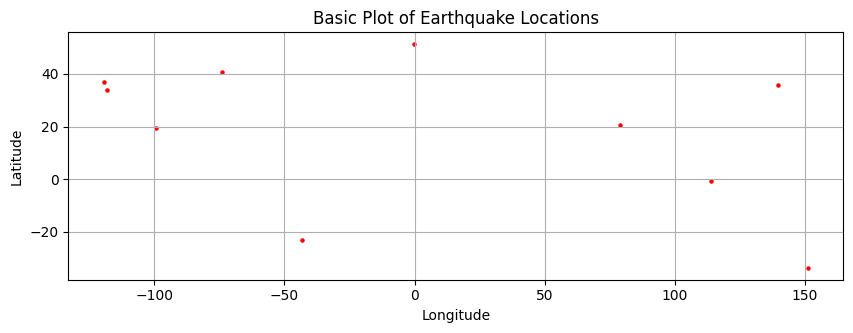

In [6]:
# Simplest plot of earthquake locations
gdf.plot(figsize=(10, 6), marker='o', color='red', markersize=5)
plt.title("Basic Plot of Earthquake Locations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

Let's make this more informative by:
1.  Plotting on a world map background.
2.  Varying marker size by earthquake magnitude.
3.  Using a colormap for magnitude.

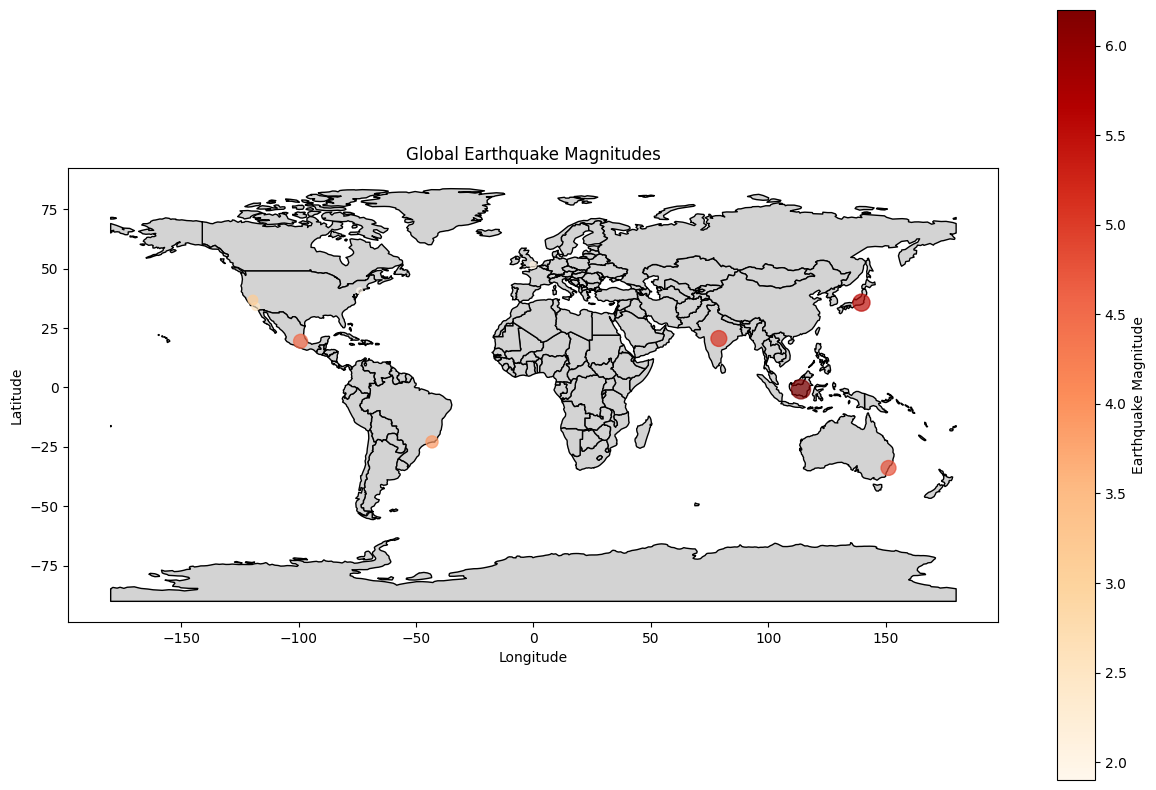

In [8]:
# Load a world map from GeoPandas datasets
import geopandas as gpd

world = gpd.read_file("../data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")

# Create a plot
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot the world map as the base
world.plot(ax=ax, color='lightgray', edgecolor='black')

# Plot the earthquakes on top
# We scale markersize: magnitude^2 * 5 to make differences more visible
gdf.plot(
    ax=ax, 
    column='magnitude', # Color by magnitude
    legend=True, 
    legend_kwds={'label': "Earthquake Magnitude"}, 
    markersize=gdf['magnitude']**2 * 5, # Size by magnitude (squared for emphasis)
    cmap='OrRd', # Color map
    alpha=0.7 # Add some transparency
)

plt.title("Global Earthquake Magnitudes")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## 6. Interactive Maps with Folium

Folium allows us to create interactive maps that you can pan, zoom, and click on. It builds on Leaflet.js.

Let's create a map centered around the mean coordinates of our earthquakes.

In [9]:
# Calculate center point for the map
map_center = [gdf['latitude'].mean(), gdf['longitude'].mean()]

# Create a Folium map object
m = folium.Map(location=map_center, zoom_start=2) # zoom_start=2 for a global view

# Add markers for each earthquake
for idx, row in gdf.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=row['magnitude'] * 1.5,  # Adjust multiplier for appropriate circle size
        popup=folium.Popup(f"<b>{row['place']}</b><br>Magnitude: {row['magnitude']}<br>Depth: {row['depth']} km", max_width=200),
        tooltip=f"{row['place']} (Mag: {row['magnitude']})",
        color='red',
        fill=True,
        fill_color='darkred',
        fill_opacity=0.6
    ).add_to(m)

# Display the map
# In a Jupyter Notebook, simply calling `m` will display it.
# To save to an HTML file: m.save('earthquake_map.html')
m

You should see an interactive map above. You can zoom in and out, and click on the circles to see popups with information about each earthquake.

## 7. Basic Data Exploration & Filtering

GeoDataFrames allow for attribute-based queries just like pandas DataFrames. Let's find all earthquakes with a magnitude greater than 5.0.

In [10]:
strong_earthquakes_gdf = gdf[gdf['magnitude'] >= 5.0]

print(f"Found {len(strong_earthquakes_gdf)} earthquakes with magnitude >= 5.0:")
strong_earthquakes_gdf[['place', 'magnitude', 'depth']]

Found 3 earthquakes with magnitude >= 5.0:


,place,magnitude,depth
3,"Tokyo, Japan",5.5,25.0
5,"Sumatra, Indonesia",6.2,30.1
7,Northern India,5.1,20.0


Now, let's plot only these strong earthquakes on an interactive map.

In [12]:
m_strong = folium.Map(location=map_center, zoom_start=2)

for idx, row in strong_earthquakes_gdf.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=row['magnitude'] * 2,  # Slightly larger radius for emphasis
        popup=f"<b>{row['place']}</b><br>Magnitude: {row['magnitude']}<br>Depth: {row['depth']} km",
        tooltip=f"{row['place']} (Mag: {row['magnitude']})",
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7
    ).add_to(m_strong)

folium.TileLayer(
    tiles='Stamen Terrain',
    attr='Map tiles by Stamen Design, CC BY 3.0 — Map data © OpenStreetMap contributors'
).add_to(m_strong)

folium.LayerControl().add_to(m_strong)

m_strong


## 8. Conclusion & Next Steps

Congratulations! You've learned the basics of geospatial analysis in Python using GeoPandas and Folium. We covered:
*   Creating GeoDataFrames from tabular data.
*   Understanding and setting Coordinate Reference Systems (CRS).
*   Making static maps with `geopandas.plot()` and `matplotlib`.
*   Building interactive maps with `folium`.
*   Filtering geospatial data based on attributes.

**Further learning:**
*   Explore the full [Kaggle Geospatial Analysis course](https://www.kaggle.com/learn/geospatial-analysis) for more in-depth topics like spatial joins, geocoding, and proximity analysis.
*   Experiment with different datasets (e.g., city locations, population density, protected areas).
*   Try other visualization libraries like `geoplot` or `plotly` for geospatial data.
*   Dive deeper into `shapely` for more complex geometric operations.
*   Explore raster data analysis with libraries like `rasterio`.